# Optimization of a State-to-State Transfer for a Quantum Charger-Battery Driven by Laser Field Using Krotov's Method

In [ ]:
pip! install drill

In [1]:
# NBVAL_IGNORE_OUTPUT
import qutip
import numpy as np
import scipy
import matplotlib
import matplotlib.pylab as plt
from src import krotov


import math
from src.krotov import Integrals as inte
import scipy.integrate as integrate

D:\ProgramData\Anaconda3\lib\site-packages\qutip\__init__.py:93: UserWarning: Old version of Cython detected: needed 0.29.20, got 0.29.15.
  .format(_cy_require, _Cython.__version__)


$\newcommand{tr}[0]{\operatorname{tr}}
\newcommand{diag}[0]{\operatorname{diag}}
\newcommand{abs}[0]{\operatorname{abs}}
\newcommand{pop}[0]{\operatorname{pop}}
\newcommand{aux}[0]{\text{aux}}
\newcommand{opt}[0]{\text{opt}}
\newcommand{tgt}[0]{\text{tgt}}
\newcommand{init}[0]{\text{init}}
\newcommand{lab}[0]{\text{lab}}
\newcommand{rwa}[0]{\text{rwa}}
\newcommand{bra}[1]{\langle#1\vert}
\newcommand{ket}[1]{\vert#1\rangle}
\newcommand{Bra}[1]{\left\langle#1\right\vert}
\newcommand{Ket}[1]{\left\vert#1\right\rangle}
\newcommand{Braket}[2]{\left\langle #1\vphantom{#2}\mid{#2}\vphantom{#1}\right\rangle}
\newcommand{op}[1]{\hat{#1}}
\newcommand{Op}[1]{\hat{#1}}
\newcommand{dd}[0]{\,\text{d}}
\newcommand{Liouville}[0]{\mathcal{L}}
\newcommand{DynMap}[0]{\mathcal{E}}
\newcommand{identity}[0]{\mathbf{1}}
\newcommand{Norm}[1]{\lVert#1\rVert}
\newcommand{Abs}[1]{\left\vert#1\right\vert}
\newcommand{avg}[1]{\langle#1\rangle}
\newcommand{Avg}[1]{\left\langle#1\right\rangle}
\newcommand{AbsSq}[1]{\left\vert#1\right\vert^2}
\newcommand{Re}[0]{\operatorname{Re}}
\newcommand{Im}[0]{\operatorname{Im}}$

This first example illustrates the basic use of the `krotov` package by solving
a simple canonical optimization problem: the transfer of population in a two
level system.

## Hamiltonian

In [2]:
import dill 
dill.settings['recurse'] = True

H0=dill.load(open("H_0", "rb"))
He=dill.load(open("H_e","rb"))
Hde=dill.load(open("H_de","rb"))



g=0.2, T=100,target= np.sqrt(2), np.sqrt(2),0,5 * np.sqrt(2), nt=100 it is good

iter.      J_T    ∫gₐ(t)dt          J       ΔJ_T         ΔJ  secs
0     1.00e+00    0.00e+00   1.00e+00        n/a        n/a     3
1     1.00e+00    6.56e+00   7.56e+00   3.35e-04   6.56e+00     7 **


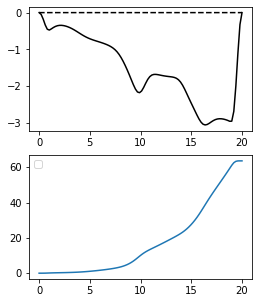

In [3]:
omega=1
ampl0=0.00001
#T=8
mu=0.5
g=0.2*omega
#ampl0=1
T=20
nt=100
tlist = np.linspace(0,T, nt)
def hamiltonian(omega, ampl0, mu,g):
      """Two-level-system Hamiltonian

      Args:
          omega (float): energy separation of the qubit levels
          ampl0 (float): constant amplitude of the driving field
      """
      HA = -1j*qutip.Qobj(H0(g))
      H1 =-1j*qutip.Qobj(Hde(mu,g))
      H2= -1j*qutip.Qobj(He(mu))
      def guess_control(t, args):
          return ampl0*krotov.shapes.flattop(
              t, t_start=0, t_stop=T, t_rise=0.005, func="blackman"
          )
      def guess_control2(t, args):
          return ampl0*krotov.shapes.flattop(
              t, t_start=0, t_stop=T, t_rise=0.005, func="blackman"
          )
      
      return [HA, [H1, guess_control], [H2, guess_control]]
def S(t):
    """Shape function for the field update"""
    return krotov.shapes.flattop(
        t, t_start=0, t_stop=T, t_rise=0.05 * T, t_fall=0.05 * T, func='sinsq'
    )
def plot_iterations(opt_result):
    """Plot the control fields in population dynamics over all iterations.

    This depends on ``store_all_pulses=True`` in the call to
    `optimize_pulses`.
    """

    fig, [ax_ctr,ax] = plt.subplots(nrows=2, figsize=(4, 5))
    n_iters = len(opt_result.iters)
    EEnergy=np.zeros(nt)
    for (iteration, pulses) in zip(opt_result.iters, opt_result.all_pulses):
        controls = [
            krotov.conversions.pulse_onto_tlist(pulse)
            for pulse in pulses
        ]
        objectives = opt_result.objectives_with_controls(controls)
        dynamics = objectives[0].mesolve(
            opt_result.tlist, e_ops=[]
        )
        if iteration == 0:
            ls = '--'  # dashed
            alpha = 1  # full opacity
            ctr_label = 'guess'
            pop_labels = ['0 (guess)', '1 (guess)']
        elif iteration == opt_result.iters[-1]:
            ls = '-'  # solid
            alpha = 1  # full opacity
            ctr_label = 'optimized'
            pop_labels = ['0 (optimized)', '1 (optimized)']
        else:
            ls = '-'  # solid
            alpha = 0.5 * float(iteration) / float(n_iters)  # max 50%
            ctr_label = None
            pop_labels = [None, None]
        ax_ctr.plot(
            dynamics.times,
            controls[0],
            label=ctr_label,
            color='black',
            ls=ls,
            alpha=alpha,
        )
    EField=np.transpose(np.array(opt_result.optimized_controls))
    EEnergy[0]=(np.square(EField[0]))*(T/nt)
    a=0
    for i in range (1,nt):
      a+=np.square(EField[i-1])
      EEnergy[i]=(np.square(EField[i])+a)*(T/nt)
      
    
    ax.plot(tlist,np.transpose(EEnergy))
    plt.legend()
    plt.show(fig)
    
    
    



H = hamiltonian(omega,ampl0,mu,g)
pulse_options = {
    H[1][1]: dict(lambda_a=0.1, update_shape=S), 

    
}
target=np.array([1,0, 2*np.sqrt(2),0,2*np.sqrt(2),1/2,0,0,0,1/2,0,0,1/2,0,1/2])
#target=np.array([1,np.sqrt(2), 2*np.sqrt(2),np.sqrt(2),2*np.sqrt(2),1/2,0,0,0,1/2,0,0,1/2,0,1/2])
r=np.pi/4
r2=np.pi/8
theta=np.pi/4
objectives = [
    krotov.Objective(
        #initial_state=qutip.Qobj(np.array([1,0,0,0,0,1/2*np.cosh(2*r2),0,-1/2*np.sinh(2*r2)*np.cos(theta),-1/2*np.sinh(2*r2)*np.sin(theta),1/2*np.cosh(2*r2),-1/2*np.sinh(2*r2)*np.sin(theta),1/2*np.sinh(2*r2)*np.cos(theta),1/2*np.cosh(2*r2),0,1/2*np.cosh(2*r2)])), target=qutip.Qobj(qutip.Qobj(np.array([1,0,0,0,0,1/2*np.cosh(2*r),0,-1/2*np.sinh(2*r)*np.cos(theta),-1/2*np.sinh(2*r)*np.sin(theta),1/2*np.cosh(2*r),-1/2*np.sinh(2*r)*np.sin(theta),1/2*np.sinh(2*r)*np.cos(theta),1/2*np.cosh(2*r),0,1/2*np.cosh(2*r)]))), H=H
        initial_state=qutip.Qobj(np.array([1,0,0,0,0,1/2,0,0,0,1/2,0,0,1/2,0,1/2])), target=qutip.Qobj(target), H=H
      )
  ]

opt_result = krotov.optimize_pulses(
  objectives,
  pulse_options=pulse_options,
  tlist=tlist,
  fieldcoupling=mu,
  propagator=krotov.propagators.expm,
  chi_constructor=krotov.functionals.chis_ss,
  info_hook=krotov.info_hooks.print_table(J_T=krotov.functionals.J_T_ss),
  check_convergence=krotov.convergence.Or(
      krotov.convergence.value_below('9e-3', name='J_T'),
      krotov.convergence.check_monotonic_error,
      #krotov.convergence.check_monotonic_fidelity,

  ),
    store_all_pulses=True,
    overlap=inte.coherent_overlap,norm='gaussiano'
)
plot_iterations(opt_result)




target=np.array([1,0.6*np.sqrt(2), 2*np.sqrt(2),-0.6*np.sqrt(2),np.sqrt(2),1/2,0,0,0,1/2,0,0,1/2,0,1/2]) for T=30 good
target=np.array([1,0.6*np.sqrt(2), 2*np.sqrt(2),-0.6*np.sqrt(2),np.sqrt(2),1/2,0,0,0,1/2,0,0,1/2,0,1/2]) for T=30 good


Plot in phase space the last state and the target for the battery

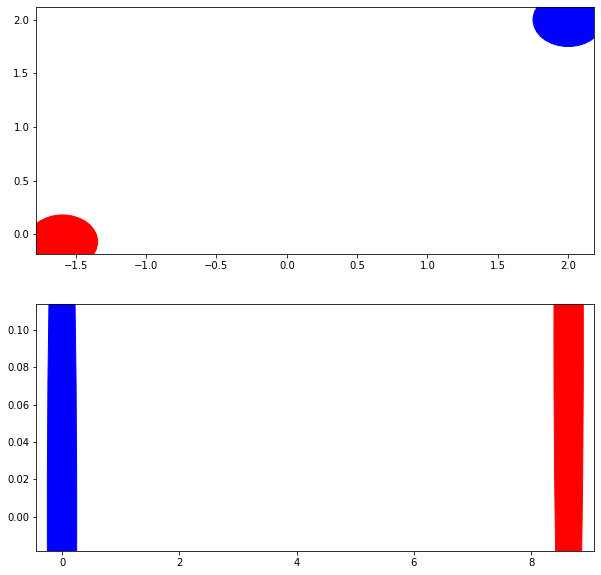

[[1.]]


In [23]:
psi=opt_result.states[0]
circle1=plt.Circle((1/np.sqrt(2)*np.real(psi[nt-1][2]), 1/np.sqrt(2)*np.real(psi[nt-1][4])), 0.25, color='r')
circle2=plt.Circle((1/np.sqrt(2)*target[2], 1/np.sqrt(2)*target[4]), 0.25, color='b')

fig, ax = plt.subplots(2,figsize=(10,10)) 

x=[1/np.sqrt(2)*np.real(psi[nt-1][2]),1/np.sqrt(2)*target[2]]
y=[1/np.sqrt(2)*np.real(psi[nt-1][4]),1/np.sqrt(2)*target[4]]

overlap1=np.exp(-np.abs(1/np.sqrt(2)*target[2]+1j*1/np.sqrt(2)*target[4]-(1/np.sqrt(2)*np.real(psi[nt-1][2])+1j*1/np.sqrt(2)*np.real(psi[nt-1][4])))**2)

ax[0].scatter(x,y)
ax[0].add_patch(circle1)
ax[0].add_patch(circle2)
#ax[0].set_ylim([-0.4, 0.3])
#ax[0].set_xlim([0.6, 2.3])


x=[1/np.sqrt(2)*np.real(psi[nt-1][1]),1/np.sqrt(2)*target[1]]
y=[1/np.sqrt(2)*np.real(psi[nt-1][3]),1/np.sqrt(2)*target[3]]


overlap2=np.exp(-np.abs(1/np.sqrt(2)*target[1]+1j*1/np.sqrt(2)*target[3]-(1/np.sqrt(2)*np.real(psi[nt-1][1])+1j*1/np.sqrt(2)*np.real(psi[nt-1][3])))**2)

circle3=plt.Circle((1/np.sqrt(2)*np.real(psi[nt-1][1]), 1/np.sqrt(2)*np.real(psi[nt-1][3])), 0.25, color='r')
circle4=plt.Circle((1/np.sqrt(2)*target[1], 1/np.sqrt(2)*target[3]), 0.25, color='b')

ax[1].scatter(x,y)
ax[1].add_patch(circle3)
ax[1].add_patch(circle4)
#ax[1].set_ylim([-1, 1])
#ax[1].set_xlim([-1, 1])

plt.show()
print(1-overlap1*overlap2)

Energy vs time

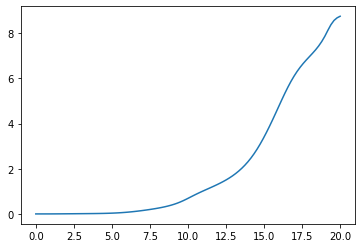

In [4]:
psi=opt_result.states[0]
Energy=np.zeros(nt)
for i in range (0,np.shape(psi)[0]):
    Energy[i]=1/2*(np.real(psi[i][9])+(np.real(psi[i][2]))**2+np.real(psi[i][14])+(np.real(psi[i][4]))**2)-1/2
    #Energy[i]=1/2*(np.real(psi[i][5])+(np.real(psi[i][1]))**2+np.real(psi[i][12])+(np.real(psi[i][3]))**2)-1/2
plt.plot(opt_result.tlist,Energy)



In [5]:
inte.opt_result.states[0][nt-1]

Quantum object: dims = [[15], [1]], shape = (15, 1), type = ket
Qobj data =
[[1.        ]
 [0.07199861]
 [0.04486285]
 [0.02484165]
 [0.02543346]
 [0.5       ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.5       ]
 [0.        ]
 [0.        ]
 [0.5       ]
 [0.        ]
 [0.5       ]]

Function to get the states at each t for optimized field

In [5]:
from scipy.integrate import simpson


def field_discrete(lista,t,dt):
    return lista[int(t/dt)]

def states(psi0,g,mu):
    HA = qutip.Qobj(H0(g))
    H1 =qutip.Qobj(Hde(mu,g))
    H2=qutip.Qobj(He(mu))
    states=np.zeros((len(opt_result.tlist),15),dtype=complex)
    integral=np.zeros(nt)

    for time_index in range(len(opt_result.tlist)-1):
        if time_index==0:
            integral[time_index]=0
        else:    
            integral[time_index]=simpson(np.array(opt_result.optimized_controls[0])[:time_index], np.array(opt_result.tlist)[:time_index])
    
    dt=opt_result.tlist[1]-opt_result.tlist[0]
    for i in range (0,len(opt_result.tlist)):
        #A=HA+H1*field_discrete(opt_result.optimized_controls[0],opt_result.tlist[i],dt)+H2*field_discrete(integral,opt_result.tlist[i],dt)
        A=HA+H1*opt_result.optimized_controls[0][i]+H2*integral[i]
        '''if i==len(opt_result.tlist)-1:
            A=HA+H2*opt_result.optimized_controls[0][i]+H1*(opt_result.optimized_controls[0][i]-opt_result.optimized_controls[0][i-1])/dt
        else:
            
            A=HA+H2*opt_result.optimized_controls[0][i]+H1*(opt_result.optimized_controls[0][i+1]-opt_result.optimized_controls[0][i])/dt'''

        if i==0:
            states[i,:]=psi0.trans()
        else:
            states[i][:]=((-A * dt).expm())(qutip.Qobj(states[i-1][:])).trans()

    return states

In [94]:
1-np.abs(inte.coherent_overlap(opt_result.states[0],qutip.Qobj(target)))**2

0.9706997877916896

In [118]:
opt_result

Krotov Optimization Result
--------------------------
- Started at 2022-01-24 17:18:42
- Number of objectives: 1
- Number of iterations: 3
- Reason for termination: Reached convergence: Loss of monotonic convergence; error decrease < 0
- Ended at 2022-01-24 17:18:51 (0:00:09)

Function to get the real field

In [6]:
def field():
    integral=np.zeros(nt)
    for time_index in range(len(opt_result.tlist)):
        if time_index==0:
            integral[time_index]=0
        else:    
            integral[time_index]=simpson(np.array(opt_result.optimized_controls[0])[:time_index], np.array(opt_result.tlist)[:time_index])
        
    return integral

Energy vs time

Electric field

-30.65462645179146


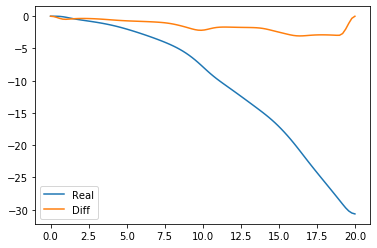

In [7]:
Efield=field()
plt.plot(opt_result.tlist,Efield,label="Real")
plt.plot(opt_result.tlist,opt_result.optimized_controls[0],label="Diff")
plt.legend()
print(Efield[nt-1])

In [146]:
for i in range(0,15):
    print(opt_result.states[0][i]-psi[nt-1][i])

[[0.+0.j]]
[[-0.09224555+0.j]]
[[0.02034789+0.j]]
[[-0.18902043+0.j]]
[[0.17992509+0.j]]
[[-1.77635684e-15+0.j]]
[[0.+0.j]]
[[0.+0.j]]
[[0.+0.j]]
[[6.10622664e-15+0.j]]
[[0.+0.j]]
[[0.+0.j]]
[[-1.88737914e-15+0.j]]
[[0.+0.j]]
[[5.55111512e-15+0.j]]


In [147]:
tlist=np.linspace(0,1,10)
for time_index in range(len(tlist) - 2, -1, -1):
    print(time_index)

8
7
6
5
4
3
2
1
0
